# 11. Collaborative Filtering - Deep Learning
## Neural Collaborative Filtering

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import OneHotEncoder
import scipy as sp
from keras.layers import Embedding, Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.models import Sequential, Model
import keras
from keras import layers
from keras import ops
import tensorflow as tf
import matplotlib.pyplot as plt


In [2]:
%run "6.Recommendations_Sample.ipynb"

Number of users 10,000
First five users id [ 9880850 11308871 10339131  8414394  9734353]


C:\Users\riccardoricci\AppData\Local\Temp\ipykernel_16052\3332260560.py:3: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  data = pickle.load(f)


Number of Rows: 12,663,134
Numbeer of Columns: 37,420
Number of stored values: 47,967,516
Number of Rows: 9,690
Numbeer of Columns: 37,420
Number of stored values: 378,793
Number of Rows: 9,691
Numbeer of Columns: 21,488
Number of stored values: 400,280


In [3]:
recommendations_sample.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id,user_id_categorical,app_id_categorical
26924891,20920,2,0,2019-11-26,1,102.2,2881,26924891,2595,455
30777575,233130,4,0,2021-08-24,1,32.0,2881,30777575,2595,1650
24970114,445980,0,0,2022-05-19,1,42.5,2881,24970114,2595,7544
30211735,1237980,0,3,2022-05-19,1,31.8,2881,30211735,2595,25073
37812169,33120,0,0,2021-04-05,1,103.5,2881,37812169,2595,622


In [4]:
user_game_matrix_k_rec.todense()

matrix([[       0,        1,        2, ...,    37399,    37401,    37414],
        [    2595,        0,        0, ...,        0,        0,        0],
        [    3376,        0,        0, ...,        0,        0,        0],
        ...,
        [12660465,        0,        0, ...,        0,        0,        0],
        [12661759,        0,        0, ...,        0,        0,        0],
        [12662371,        0,        0, ...,        0,        0,        0]],
       dtype=int32)

In [5]:
%run "Get_Training_and_Test_Instances.ipynb"

C:\Users\riccardoricci\AppData\Local\Temp\ipykernel_16052\3121204030.py:6: FutureWarning: The provided callable <function nanmax at 0x000002147F976AF0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  max_df = df.groupby("user_id_categorical").agg({"date": np.nanmax}).reset_index()


x_test.shape (12959, 2)
y_test.shape (12959, 1)
Number of Users: 9,690
Number of Games: 21,487
x_train.shape (1834864, 2)
y_train.shape (1834864, 2)


## Create the model

In [6]:
# EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    # def __init__(self, num_users, num_items, embedding_size, num_units_layers=[64,32],  **kwargs):
    def __init__(self, num_users, num_items, num_units_layers,  **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        # embeddings reduce the dimensionality, they are like look up tables
        # self.embedding_size = embedding_size
        self.user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
        self.item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
        self.user_embedding = layers.Embedding(
            input_dim=num_users,
            output_dim= int(num_units_layers[0]/2), # embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # self.user_bias = layers.Embedding(num_users, 1)
        
        self.game_embedding = layers.Embedding(
            input_dim=num_items,
            output_dim= int(num_units_layers[0]/2), # embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # self.game_bias = layers.Embedding(num_items, 1)

        # 
        self.flatten_users = layers.Flatten()
        self.flatten_games = layers.Flatten()
        self.concat_users_games = layers.Concatenate()
        self.dense_layer_1 = layers.Dense(
            units = num_units_layers[0],
            activation = "relu",
            kernel_initializer="glorot_uniform"
        )
        self.dense_layer_2 = layers.Dense(
            units = num_units_layers[1],
            activation = "relu",
            kernel_initializer="glorot_uniform"
        )
        self.prediction = layers.Dense(
            units = 1,
            activation = "sigmoid",
            input_dim = num_units_layers[1]
        )


    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:,0])
        # user_bias = self.user_bias(inputs[:,0])
        game_vector = self.game_embedding(inputs[:,1])
        # game_bias = self.game_bias(inputs[:,1])
        # dot_user_game = ops.tensordot(user_vector, game_vector, 2)
        # x = dot_user_game + user_bias + game_bias
        users_flat = self.flatten_users(user_vector)
        # print(users_flat.shape)
        games_flat = self.flatten_games(game_vector)
        concat = self.concat_users_games([users_flat, games_flat])
        dense_layer_1 = self.dense_layer_1(concat)
        dense_layer_2 = self.dense_layer_2(dense_layer_1)
        prediction = self.prediction(dense_layer_2)
        # return ops.nn.softmax(prediction)    
        # return ops.nn.sigmoid(x)
        return prediction # ops.nn.sigmoid(prediction)


# model = RecommenderNet(num_users, num_items, EMBEDDING_SIZE)
model = RecommenderNet(num_users, num_items, [100,50])
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001), # Adagrad is suited for sparse data
    # metrics=['accuracy']
)

c:\Users\riccardoricci\.conda\envs\NCF\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
%run "Model_Evaluation.ipynb"

In [8]:
epochs=10
n_users2val = 5
K = 10
num_users, num_games = train.shape

In [9]:
avg_precision_train = []
hgr_test = []


In [10]:
for epoch in np.arange(epochs):
    history = model.fit(
    x=x_train, # user_idx and app_idx
    y=y_train, # recommendations, always 1
    #batch_size=64, # Number of samples per gradient update aka Minibatch Gradient Descent
    epochs=1, # Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
    verbose=1, # progress line
    validation_data=(x_test, y_test) # Data on which to evaluate the loss and any model metrics at the end of each epoch  
    )
    print("########################################## Epoch:", epoch, "###########################################")
    print("######## Training Data #####")

    prec, rec = eval_k_avg(n_users2val, K, num_users, num_games, x_train, y_train)
    print("Number of users:", n_users2val)
    print("K:",K)
    print("Average Precision", '{0:.4%}'.format(prec))
    print("Average Recall", '{0:.4%}'.format(rec))
    avg_precision_train.append((prec, rec))
    print("######## Training Data #####")

    hit_r = eval_hit_ratio(n_users2val, K, num_games, x_test)
    hgr_test.append(hit_r)
    print("Number of users:", n_users2val)
    print("K:",K)
    print("Hit Ratio:", '{0:.4%}'.format(hit_r))

  851/57340 ━━━━━━━━━━━━━━━━━━━━ 6:07 7ms/step - loss: 0.4746

KeyboardInterrupt: 

In [55]:
avg_precision_train

[(0.04, 0.017424242424242425),
 (0.1, 0.037265512265512266),
 (0.24, 0.03333478799791391),
 (0.08, 0.01999605988967691),
 (0.16, 0.07169642857142858),
 (0.08, 0.025140712945590993),
 (0.14, 0.05372532631687561),
 (0.12, 0.042556932212104624),
 (0.2, 0.05363538152388327),
 (0.12, 0.035473032714412024)]

In [56]:
avg_prec_train = [x[0] for x in avg_precision_train]
avg_recal_train = [x[1] for x in avg_precision_train]

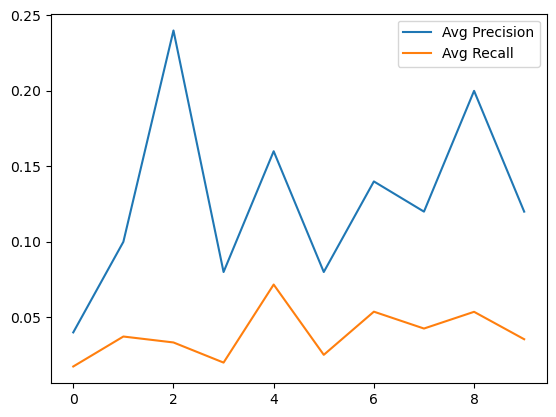

In [57]:
plt.plot(avg_prec_train, label='Avg Precision')
plt.plot(avg_recal_train, label='Avg Recall')
plt.legend()
plt.show()

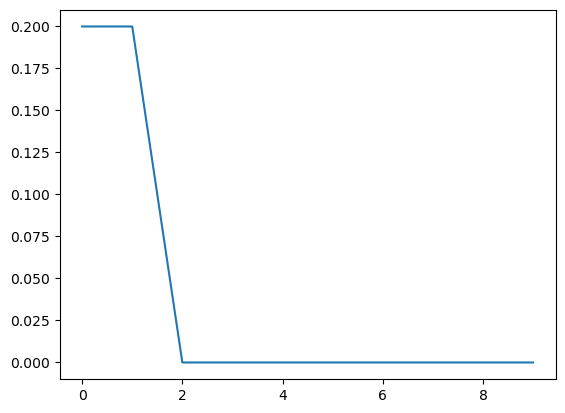

In [60]:
plt.plot(hgr_test)
plt.show()

In [61]:
# plt.plot(history.history["loss"])
# plt.plot(history.history["val_loss"])
# plt.title("model loss")
# plt.ylabel("loss")
# plt.xlabel("epoch")
# plt.legend(["train", "test"], loc="upper left")
# plt.show()

## Model Evaluation

In [62]:
x_train

array([[    0,    20],
       [    0,   279],
       [    0,   297],
       ...,
       [ 4915, 16815],
       [ 4915, 16967],
       [ 4915, 17057]])

In [63]:
y_train

array([[1],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [64]:
x_test

array([[    0, 12246],
       [    1, 11826],
       [    2, 15161],
       ...,
       [ 4913,  2208],
       [ 4914,  9434],
       [ 4915, 12246]], dtype=int64)

In [65]:
y_test

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])